In [1]:
!pip install emot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 KB 7.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing import text
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from emot.emo_unicode import UNICODE_EMOJI
emoji = list(UNICODE_EMOJI.keys())
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentiment_pilkada_DKI_2017.csv')
df

,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...
...,...,...,...,...
895,896,positive,Anies-Sandi,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ..."
896,897,positive,Anies-Sandi,Kita harus dapat merangkul semua orang tanpa b...
897,898,positive,Anies-Sandi,Ini jagoanku dibidang digital <Smiling Face Wi...
898,899,positive,Anies-Sandi,#PesanBijak #OkeOce #GubernurGu3 ...


# Praproses dan EDA

In [4]:
df.duplicated().sum()

0

In [5]:
print(set(df['Sentiment']))

{'negative', 'positive'}


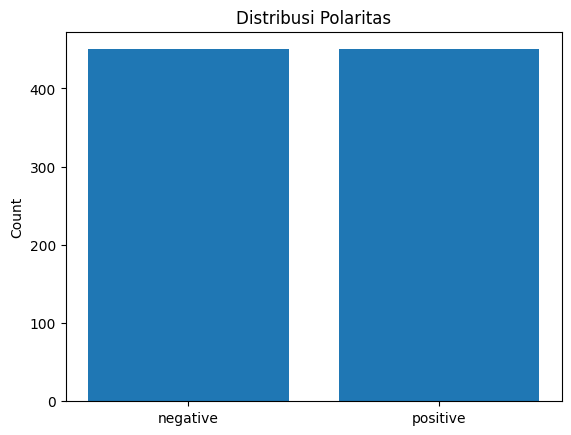

Positive :  450
Negative :  450


In [6]:
classes = df["Sentiment"].unique()
y_axis = [df[df["Sentiment"] == "positive"].shape[0], df[df["Sentiment"] == "negative"].shape[0]]

# Membuat barplot sentimen
plt.bar(classes, y_axis)
plt.ylabel("Count")
plt.title("Distribusi Polaritas")
plt.show()

print("Positive : ", len(df[df["Sentiment"] == "positive"]))
print("Negative : ", len(df[df["Sentiment"] == "negative"]))

In [7]:
print(set(df['Pasangan Calon']))

{'Ahok-Djarot', 'Anies-Sandi', 'Agus-Sylvi'}


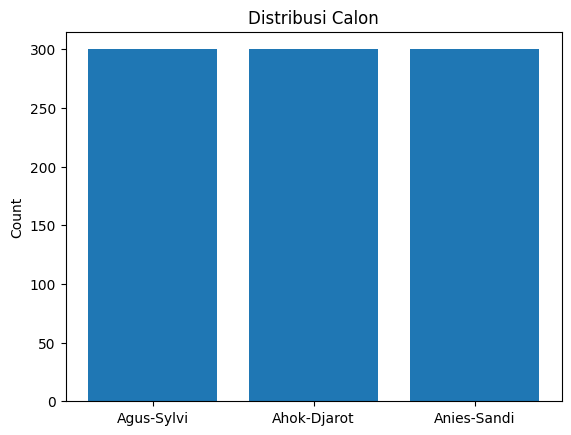

Agus-Sylvi  :  300
Ahok-Djarot :  300
Anies-Sandi :  300


In [8]:
classes = df["Pasangan Calon"].unique()
y_axis = [df[df["Pasangan Calon"] == "Agus-Sylvi"].shape[0],
          df[df["Pasangan Calon"] == "Anies-Sandi"].shape[0],
          df[df['Pasangan Calon'] == 'Ahok-Djarot'].shape[0]]

# Membuat barplot paslon
plt.bar(classes, y_axis)
plt.ylabel("Count")
plt.title("Distribusi Calon")
plt.show()

print("Agus-Sylvi  : ", len(df[df["Pasangan Calon"] == "Agus-Sylvi"]))
print("Ahok-Djarot : ", len(df[df["Pasangan Calon"] == "Ahok-Djarot"]))
print("Anies-Sandi : ", len(df[df["Pasangan Calon"] == "Anies-Sandi"]))

In [9]:
stopwords = pd.read_csv("https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/stopword_tweet_pilkada_DKI_2017.csv")
stopwords = np.append(stopwords, "rt")

# function for preprocessing tweet in preparation for sentiment analysis
def processed_tweets(text):
    text = text.lower() 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split())
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text)
    punct = str.maketrans('', '', string.punctuation+string.digits)
    text = text.translate(punct)
    # tokenizing words and removing stop words from the tweet text
    tokens = word_tokenize(text)  
    filtered_words = [w for w in tokens if w not in stopwords]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # lemmetizing words
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    return text

In [10]:
df['tweet_bersih'] = df['Text Tweet'].apply(processed_tweets)
df

,Id,Sentiment,Pasangan Calon,Text Tweet,tweet_bersih
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...,akun kloning pendukung menyerang paslon opini ...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...,bicara kasihan yaalap air matanya wkwkwkwk
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...,sih nunggu hasil qc tp nunggu motif cuitan kay...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...,kasian oh kasian peluru milyar rw mempan menan...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf pendukung hayo dukung diputaran
...,...,...,...,...,...
895,896,positive,Anies-Sandi,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ...",kali bpk lihat rspun selfie ok hand
896,897,positive,Anies-Sandi,Kita harus dapat merangkul semua orang tanpa b...,merangkul orang bata usia kelamin ok hand vict...
897,898,positive,Anies-Sandi,Ini jagoanku dibidang digital <Smiling Face Wi...,jagoanku dibidang digital smiling face with su...
898,899,positive,Anies-Sandi,#PesanBijak #OkeOce #GubernurGu3 ...,


In [11]:
# Melihat perubahan sebelum dan sesudah praproses data
print('Tweet kotor: ', df['Text Tweet'].iloc[5])
print('Tweet bersih: ', df['tweet_bersih'].iloc[5])

Tweet kotor:  aneh deh lebay masa ini di sangkut pautkan sama kandidat Calgub, anda lebay seperti yg anda dukung #agussilvy
Tweet bersih:  aneh deh lebay sangkut pautkan kandidat calgub lebay dukung


In [12]:
def polaritas(teks):
  if teks =='positive':
    return 1
  elif teks =='negative':
    return -1

In [13]:
# Membuat kolom 'label' untuk membuat sentimen menjadi numerik
df['label'] = df['Sentiment'].apply(polaritas)
df

,Id,Sentiment,Pasangan Calon,Text Tweet,tweet_bersih,label
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...,akun kloning pendukung menyerang paslon opini ...,-1
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...,bicara kasihan yaalap air matanya wkwkwkwk,-1
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...,sih nunggu hasil qc tp nunggu motif cuitan kay...,-1
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...,kasian oh kasian peluru milyar rw mempan menan...,-1
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf pendukung hayo dukung diputaran,-1
...,...,...,...,...,...,...
895,896,positive,Anies-Sandi,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ...",kali bpk lihat rspun selfie ok hand,1
896,897,positive,Anies-Sandi,Kita harus dapat merangkul semua orang tanpa b...,merangkul orang bata usia kelamin ok hand vict...,1
897,898,positive,Anies-Sandi,Ini jagoanku dibidang digital <Smiling Face Wi...,jagoanku dibidang digital smiling face with su...,1
898,899,positive,Anies-Sandi,#PesanBijak #OkeOce #GubernurGu3 ...,,1


In [14]:
df_agus_neg = df[(df['Pasangan Calon']=='Agus-Sylvi') & (df['label']==-1)].iloc[:,-2:]
df_agus_pos = df[(df['Pasangan Calon']=='Agus-Sylvi') & (df['label']==1)].iloc[:,-2:]
df_ahok_neg = df[(df['Pasangan Calon']=='Ahok-Djarot') & (df['label']==-1)].iloc[:,-2:]
df_ahok_pos = df[(df['Pasangan Calon']=='Ahok-Djarot') & (df['label']==1)].iloc[:,-2:]
df_anies_neg = df[(df['Pasangan Calon']=='Anies-Sandi') & (df['label']==-1)].iloc[:,-2:]
df_anies_pos = df[(df['Pasangan Calon']=='Anies-Sandi') & (df['label']==1)].iloc[:,-2:]

In [15]:
df_ahok_pos

,tweet_bersih,label
450,pdip perkuat kemenangan ahokdjarot,1
451,pemenang sesungguhnya mengalah jakarta pecah p...,1
452,hujan sembako ahokdjarot sedekah aniessandi,1
453,hitungan pemenang sesungguhnya mengalah kepent...,1
454,terima kasih ahok btp,1
...,...,...
595,ahok jarot membereskan jakarta folded hand fol...,1
596,program ahokdjarot victory hand victory hand a...,1
597,ala ustad cang haris pilih victory hand lupa n...,1
598,usul team btp bergerak sosialisasi programkerj...,1


In [16]:
# Import Library WordCloud. WordCloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul.
# Import Library cv2 untuk mengolah gambar menjadi masking WordCloud

import cv2
from wordcloud import WordCloud

In [17]:
# Download gambar masking
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

--2023-04-08 05:21:37--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg’

cloud.jpg           100%[===================>]  33.59K  --.-KB/s    in 0s      

2023-04-08 05:21:38 (148 MB/s) - ‘cloud.jpg’ saved [34396/34396]



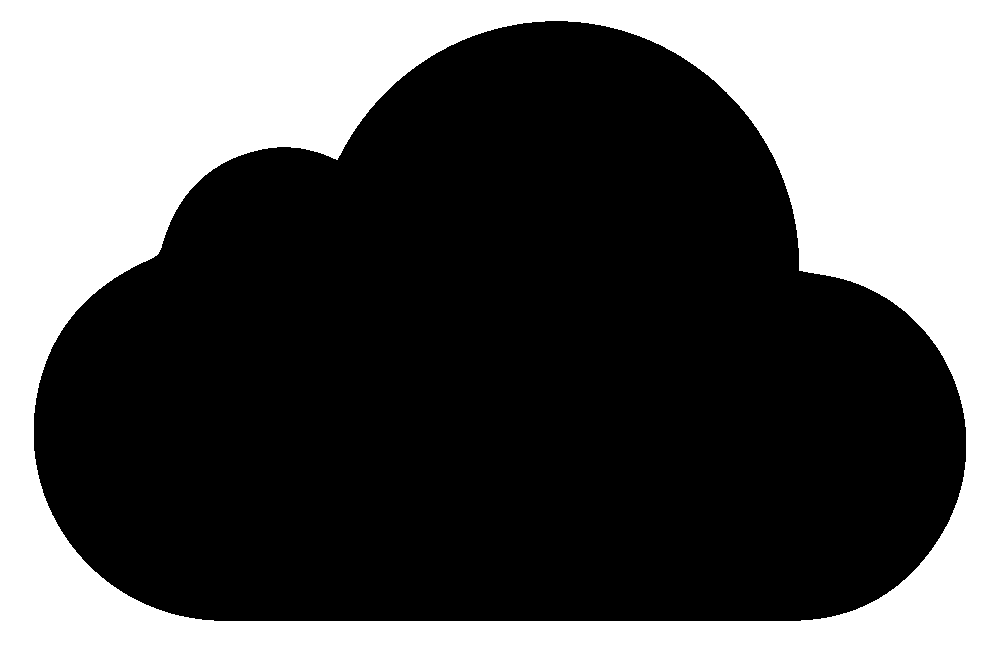

In [18]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

# Tampilkan masking
from google.colab.patches import cv2_imshow

cv2_imshow(cloud_mask)

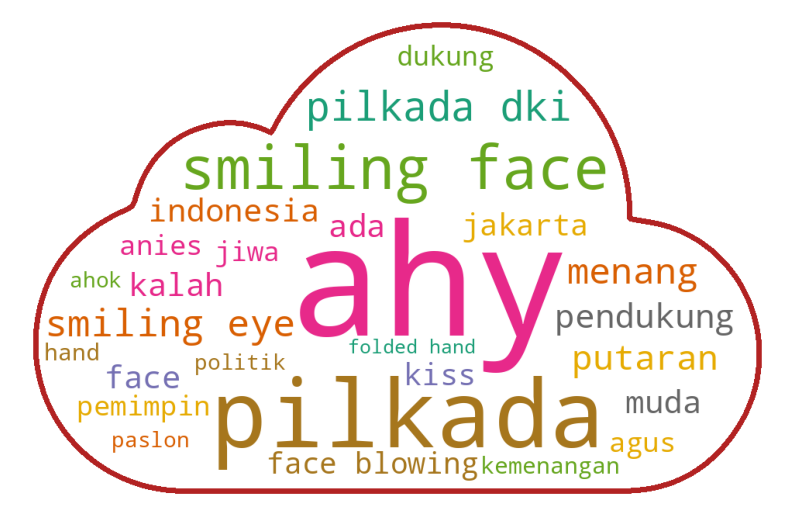

In [19]:
# WordCloud cuit positif untuk Agus-Sylvi

agus_pos = df_agus_pos
normal_string = []

for t in agus_pos.tweet_bersih:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

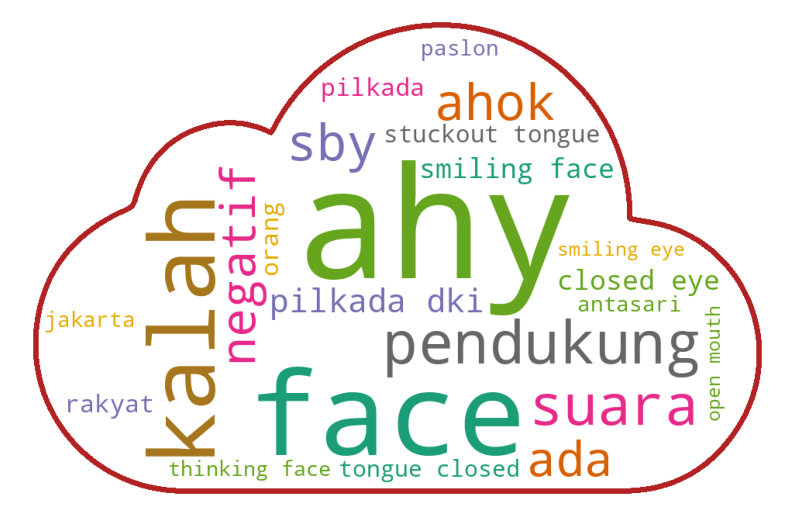

In [20]:
# WordCloud cuit negatif untuk Agus-Sylvi

agus_neg = df_agus_neg
normal_string = []

for t in agus_neg.tweet_bersih:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

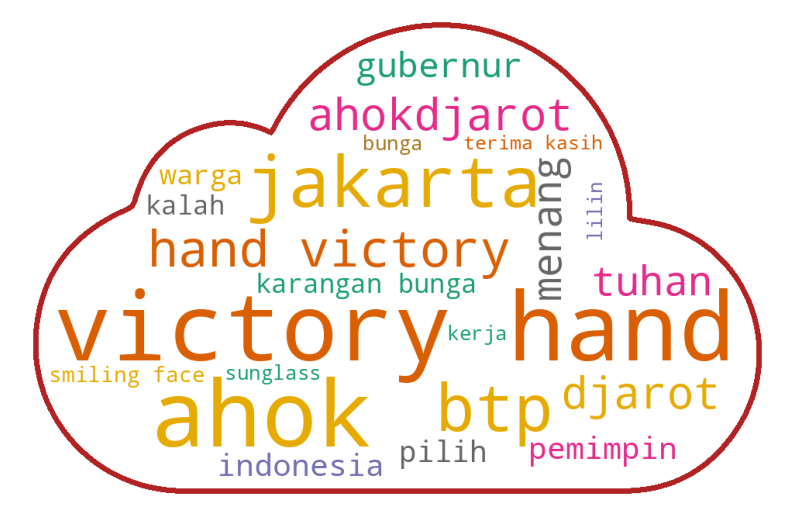

In [21]:
# WordCloud cuit positif untuk Ahok-Djarot

ahok_pos = df_ahok_pos
normal_string = []

for t in ahok_pos.tweet_bersih:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

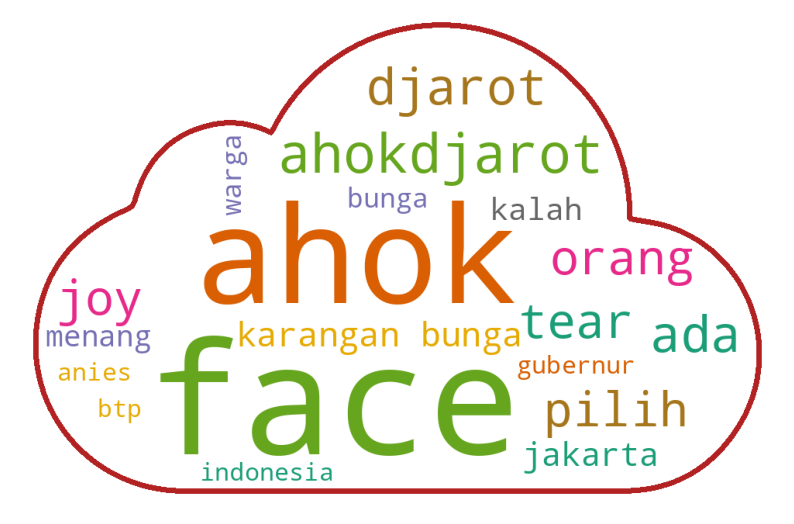

In [22]:
# WordCloud cuit negatif untuk Ahok-Djarot

ahok_neg = df_ahok_neg
normal_string = []

for t in ahok_neg.tweet_bersih:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

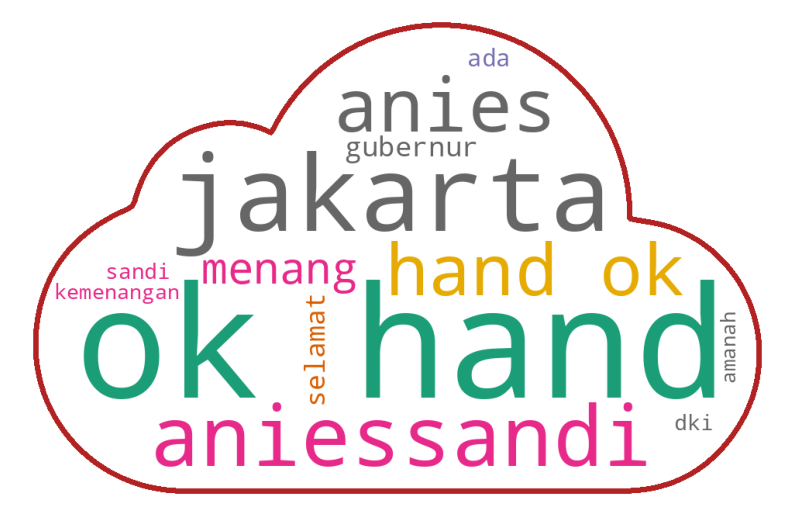

In [23]:
# WordCloud cuit positif untuk Anies-Sandi

anies_pos = df_anies_pos
normal_string = []

for t in anies_pos.tweet_bersih:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

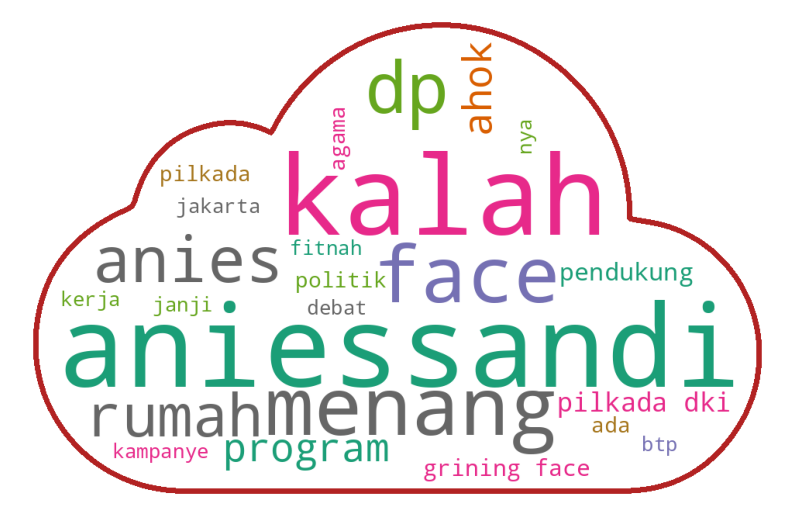

In [24]:
# WordCloud cuit negatif untuk Anies-Sandi

anies_neg = df_anies_neg
normal_string = []

for t in anies_neg.tweet_bersih:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Feature Engineering

In [25]:
# Pisahkan kolom fitur dan target
x = df['tweet_bersih']
y = df['label']

In [26]:
import pickle

In [27]:
# Feature Extraction (TF-IDF & N-Gram)
# Proses mengubah teks menjadi vector menggunakan metode TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(x)

TfidfVectorizer()

In [28]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

2675


In [29]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aa' 'aamiin' 'abal' ... 'zalim' 'zippermouth' 'zona']


In [30]:
x_tf_idf = tf_idf.transform(x).toarray()    # Melihat matriks jumlah token
data_tf_idf = pd.DataFrame(x_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aamiin,abal,abang,abis,absurd,abunawas,aburizal,abused,acara,...,yes,yme,youtubebxrzdua,yra,yudhoyono,yuk,yusuf,zalim,zippermouth,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(x_tf_idf, output)

In [32]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
x = np.array(data_tf_idf)
y = np.array(y)

In [33]:
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Feature Selection (Chi Square)
# 450 features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=450) 
x_kbest_features = chi2_features.fit_transform(x, y) 
  
# Reduced features 
print('Original feature number:', x.shape[1]) 
print('Reduced feature number:', x_kbest_features.shape[1])

Original feature number: 2675
Reduced feature number: 450


In [34]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.071872,aa
1,0.088804,aamiin
2,0.093096,abal
3,1.127026,abang
4,0.752611,abis
...,...,...
2670,0.909471,yuk
2671,0.375868,yusuf
2672,0.792124,zalim
2673,2.104600,zippermouth


In [35]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
788,16.862238,hand
1733,9.335971,ok
2613,8.992506,victory
926,6.261285,jakarta
2211,3.664188,selamat
...,...,...
2482,0.000015,thumb
375,0.000010,buruh
752,0.000007,gratis
2656,0.000005,yaaa


In [36]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False, False, ...,  True,  True, False])

In [37]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['abang',
 'abis',
 'agama',
 'agus',
 'agussylvi',
 'ahokers',
 'ahysilvy',
 'ahysylvi',
 'akibat',
 'akun',
 'alat',
 'alien',
 'allahuakbar',
 'ama',
 'amanah',
 'aneh',
 'antasari',
 'apaapa',
 'at',
 'awas',
 'bagus',
 'bahagia',
 'bangga',
 'bangsa',
 'banjir',
 'bapaknya',
 'baper',
 'barisan',
 'baskoro',
 'basukibtp',
 'batam',
 'bawa',
 'bayar',
 'bayaran',
 'bebas',
 'beberkan',
 'bego',
 'belom',
 'benci',
 'bener',
 'berani',
 'berbuat',
 'berdemokrasi',
 'berdoa',
 'beretorika',
 'berita',
 'berjiwa',
 'berkati',
 'berlaku',
 'berlari',
 'berpolitik',
 'bersatu',
 'bersih',
 'betawi',
 'bicara',
 'bijaksana',
 'bikin',
 'bini',
 'blowing',
 'blunder',
 'bogor',
 'bosan',
 'buang',
 'bukti',
 'bully',
 'bunganya',
 'buzzer',
 'cagub',
 'cakeeepppp',
 'cari',
 'catatan',
 'cek',
 'check',
 'closed',
 'cocok',
 'cold',
 'coldplay',
 'contoh',
 'count',
 'cuitan',
 'dada',
 'dah',
 'darah',
 'debat',
 'dibawah',
 'didukung',
 'dihati',
 'dilantik',
 'dipakai',
 'diperhitungka

In [38]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF-IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [39]:
kbest_feature

{'akun': 49,
 'menyerang': 1541,
 'bicara': 315,
 'kasihan': 1027,
 'matanya': 1356,
 'cuitan': 447,
 'kayak': 1033,
 'nyungsep': 1725,
 'kasian': 1025,
 'oh': 1731,
 'rw': 2131,
 'aneh': 85,
 'suara': 2335,
 'kasih': 1026,
 'teruntuk': 2472,
 'survey': 2360,
 'karna': 1020,
 'om': 1742,
 'kalah': 993,
 'mulut': 1615,
 'sby': 2178,
 'melanggar': 1374,
 'ama': 68,
 'jd': 947,
 'otomatis': 1766,
 'dukungannya': 647,
 'lari': 1247,
 'gara': 720,
 'miskin': 1585,
 'antasari': 102,
 'melempem': 1383,
 'modal': 1587,
 'jatim': 943,
 'agus': 19,
 'maju': 1309,
 'gembosi': 731,
 'sang': 2157,
 'semangat': 2222,
 'isu': 913,
 'video': 2614,
 'buzzer': 381,
 'awas': 139,
 'ye': 2662,
 'tanoe': 2396,
 'mayor': 1363,
 'berbuat': 243,
 'bully': 367,
 'sayang': 2175,
 'pemimpin': 1860,
 'banjir': 179,
 'pakai': 1774,
 'cari': 398,
 'gubernur': 761,
 'lapang': 1243,
 'dada': 451,
 'menang': 1421,
 'bayaran': 201,
 'kelompok': 1085,
 'kehilangan': 1069,
 'memilih': 1410,
 'ni': 1685,
 'blunder': 333,


In [40]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(x_kbest_features, columns=selected_feature)
data_selected_feature

,abang,abis,agama,agus,agussylvi,ahokers,ahysilvy,ahysylvi,akibat,akun,...,voter,waaah,wajah,wakil,waras,ye,yudhoyono,yuk,zalim,zippermouth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.303679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

# Modelling

In [42]:
from sklearn.naive_bayes import BernoulliNB             # Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x_kbest_features, y, test_size=0.2, random_state=42)

In [44]:
# Training the model
algorithm = BernoulliNB()                 # Load algoritma Naive Bayes
model = algorithm.fit(x_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

['model_1.joblib']

In [45]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(x_test)

# Tampilkan hasil prediksi label dari model
model_pred

array([-1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,
        1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,
       -1,  1, -1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1,  1,
       -1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1,
        1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,
        1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
       -1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,
        1,  1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1,
        1, -1, -1, -1,  1,  1,  1,  1,  1, -1])

In [46]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier()
NN.fit(x_train, y_train)

# Simpan model hasil traning
dump(NN, filename='model_2.joblib')

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['model_2.joblib']

In [47]:
model2_pred = NN.predict(x_test)

# Model Evaluation

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[67 24]
 [ 7 82]]


In [49]:
cm2 = confusion_matrix(y_test, model2_pred)
print('Confusion matrix:\n', cm2)

Confusion matrix:
 [[78 13]
 [30 59]]


In [50]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

          -1       0.91      0.74      0.81        91
           1       0.77      0.92      0.84        89

    accuracy                           0.83       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.83      0.83       180



In [51]:
print('Classification report:\n', classification_report(y_test, model2_pred))

Classification report:
               precision    recall  f1-score   support

          -1       0.72      0.86      0.78        91
           1       0.82      0.66      0.73        89

    accuracy                           0.76       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.77      0.76      0.76       180



In [52]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

cv_accuracy = (cross_val_score(model, x_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.82777778 0.78888889 0.82777778 0.82222222 0.81666667 0.77222222
 0.83333333 0.8        0.83888889 0.81111111] 

Rata-rata akurasi pada cross validation: 0.8138888888888889


In [53]:
cv2_accuracy = (cross_val_score(NN, x_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv2_accuracy)

print('Akurasi setiap split:', cv2_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

Akurasi setiap split: [0.76111111 0.83333333 0.80555556 0.74444444 0.82222222 0.8
 0.85       0.78888889 0.86666667 0.82777778] 

Rata-rata akurasi pada cross validation: 0.8099999999999999


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Simple Deployment

In [54]:
from joblib import load

# load model
model = load('model_1.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

In [56]:
#@title Masukkan Teks Anda:
input_text = "janjimu manis apakah bisa kerja" #@param {type:"string"}

pre_input_text = processed_tweets(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result==-1):
  cuit = 'Cuit negatif'
elif (result==1):
  cuit = 'Cuit positif'

print('Hasil prediksi', input_text, ' adalah\n', cuit)

Hasil Text Preprocessing : janjimu manis kerja
Hasil prediksi janjimu manis apakah bisa kerja  adalah
 Cuit positif
